In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("../../")
from TCN.soil_classification.model import SimpleVAE
from TCN.soil_classification.utils import data_generator, data_generator_test
from TCN.soil_classification.model_VAE import DenseVAE, ConvVAE

from sklearn.manifold import TSNE

In [24]:
# Definitions for data indicies
LIN_ACC_X = 1
LIN_ACC_Y = 2
LIN_ACC_Z = 3
ANG_VEL_X = 4
ANG_VEL_Y = 5
ANG_VEL_Z = 6
ORIENT_X = 7
ORIENT_Y = 8
ORIENT_Z = 9
ORIENT_W = 10
POS_X = 11
POS_Z = 12
ANG = 13
BOOM = 14
DIPPER = 15
TELE = 16
PITCH = 17
labels = ["lin_acc_x","lin_acc_y","lin_acc_z","ang_vel_x","ang_vel_y","ang_vel_z", "ori_x", "ori_y",
          "ori_z", "ori_w", "pos_x", "pos_z", "ang", "boom", "dipper", "tele", "pitch"]

In [51]:
DenseVAE_small = "AE_model/DenseVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/DenseVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
DenseVAE_large = "AE_model/DenseVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf240/DenseVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf240_ep64.pt"
ConvVAE_large = "AE_model/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf5/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf5_ep64.pt"
ConvVAE_small = "AE_model/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf60/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf60_ep64.pt"
ConvVAE_8 = "AE_model/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
ConvVAE_8_2 = "AE_model/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"

ConvVAED_8 = "AE_model/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8_ep128.pt"
ConvVAED_8_11 = "AE_model/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep128.pt"
ConvVAED_8_norm = "AE_model/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8_ep128.pt"
ConvVAED_8_grad = "AE_model/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8_ep128.pt"
convVAED_8_seqstandard = "AE_model/ConvVAED_Test15_bs256_do0_seq128_imu_no_orient_seq_standard_phase2_nlf8/ConvVAED_Test15_bs256_do0_seq128_imu_no_orient_seq_standard_phase2_nlf8_ep128.pt"
ConvVAED_8_aug = "AE_model/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_augment_phase2_nlf8/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_augment_phase2_nlf8_ep128.pt"
ConvVAED_8_norm_grad = "AE_model/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8_ep128.pt"


train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/prelim_downsample_phase"
val_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"

#variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))+list(range(BOOM,PITCH+1,1))]
#variable_set = [list(range(BOOM,PITCH+1,1))]
variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))]
seq_len = 128
phase = 2

X_train, Y_train = data_generator(train_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])
X_test, Y_test, plotting, files = data_generator_test(test_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])

print(X_train.shape)

norm = True
derivative = True
seq_standard = False
if norm:
    X_train[:,:,0] = torch.linalg.norm(X_train[:,:,0:3], dim = 2)
    X_train[:,:,1] = torch.linalg.norm(X_train[:,:,3:6], dim = 2)
    X_train = X_train[:,:,[0,1]+list(range(6,X_train.shape[2],1))]

if derivative:
    X_train = torch.from_numpy(np.gradient(X_train, axis=1))
    
if seq_standard:
    m = X_train.mean(axis=1).unsqueeze(1)
    s = X_train.std(axis=1).unsqueeze(1)
    X_train -= m
    X_train /= s

    
m = X_train.mean(0, keepdim=True)
s = X_train.std(0, unbiased=False, keepdim=True)

X_train -= m
X_train /= s
X_train = X_train.permute(0,2,1)

for traj_idx in range(len(X_test)):
    if norm:
        X_test[traj_idx][:,:,0] = torch.linalg.norm(X_test[traj_idx][:,:,0:3], dim = 2)
        X_test[traj_idx][:,:,1] = torch.linalg.norm(X_test[traj_idx][:,:,3:6], dim = 2)
        X_test[traj_idx] = X_test[traj_idx][:,:,[0,1]+list(range(6,X_test[traj_idx].shape[2],1))]
        
    if derivative:
            X_test[traj_idx] = torch.from_numpy(np.gradient(X_test[traj_idx], axis=1))

    if seq_standard:
        m = X_test[traj_idx].mean(axis=1).unsqueeze(1)
        s = X_test[traj_idx].std(axis=1).unsqueeze(1)
        X_test[traj_idx] -= m
        X_test[traj_idx] /= s
    X_test[traj_idx] -= m
    X_test[traj_idx] /= s
    X_test[traj_idx] = X_test[traj_idx].permute(0,2,1)

channel_sizes = [30,30,30,30,30,4]#[30]*6 #[30,20,10,1]#
kernel_size = 7
input_channels = X_train.shape[1]
latent_dim = 8

hidden_dims = [1000,800,500, 240]

#model = DenseTCNAE(input_channels, latent_dim, seq_len, channel_sizes, kernel_size=kernel_size, dropout = 0.25)


#model = ConvTCNAE(input_channels, 10, channel_sizes, kernel_size=kernel_size, dropout = 0.25)

#model = DenseVAE(input_channels, seq_len, latent_dim, hidden_dims)
#model.load_state_dict(torch.load(DenseVAE_large))

model = ConvVAE(input_channels, channel_sizes, kernel_size)
model.load_state_dict(torch.load(ConvVAED_8_norm_grad))

model.eval()

torch.Size([11628, 128, 6])


ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (5): Sequential(
      (0): Conv1d(30, 4, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
  )
  (mu): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
  (logvar): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose1d(4, 30, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
      (1): ReL

In [52]:
with torch.no_grad():
    model.eval()
    output = []
    for x in X_test:
        output.append(model(x))

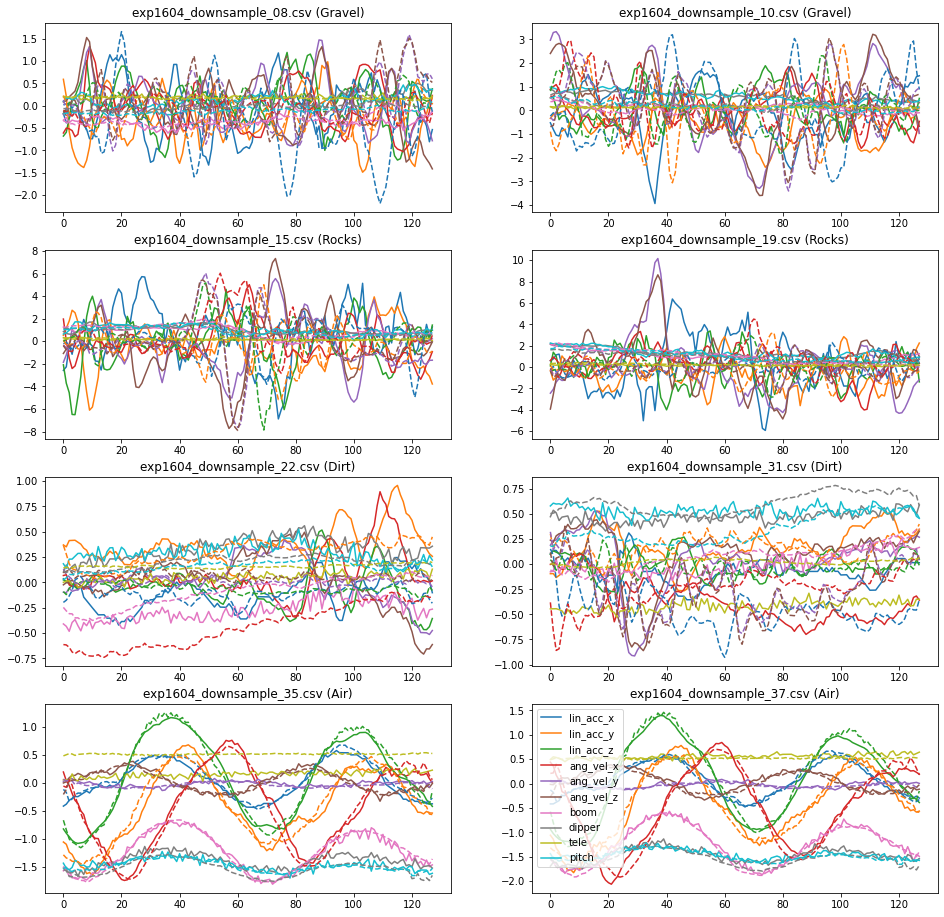

In [20]:
idx = 120
soil_class = ["Gravel","Gravel","Rocks","Rocks","Dirt","Dirt","Air","Air"]
soil_class = ["Air","Gravel","Dirt","Rocks"]
legend = [labels[i-1] for i in variable_set[0]]
rows = int((len(plotting)+1)/2) 
fig, ax1 = plt.subplots(rows,2,figsize = [16,4*rows])
for a1,d,f,out,s in zip(ax1.reshape(-1),plotting,files,output,Y_test):
    a1.title.set_text(f+f" ({soil_class[s[0]]})")
    a1.set_prop_cycle(None)
    a1.plot(out[1][idx].T)   
    a1.set_prop_cycle(None)
    a1.plot(out[0][idx].T,linestyle="--")
plt.legend(legend)
plt.show()

## t-SNE Test Set

In [53]:
colors = ["r", "g", "b", "c"]

x_te = torch.cat(X_test)
y_te = torch.cat(Y_test)

with torch.no_grad():
    model.eval()
    encoded_test = model.encode(x_te)
    encoded_test = model.reparameterize(*encoded_test)
    encoded_train = model.encode(X_train)
    encoded_train = model.reparameterize(*encoded_train)

test_len = encoded_test.shape[0]
encoded = torch.cat((encoded_test,encoded_train))
    
projected = TSNE(n_components=2).fit_transform(torch.flatten(encoded, start_dim=1))

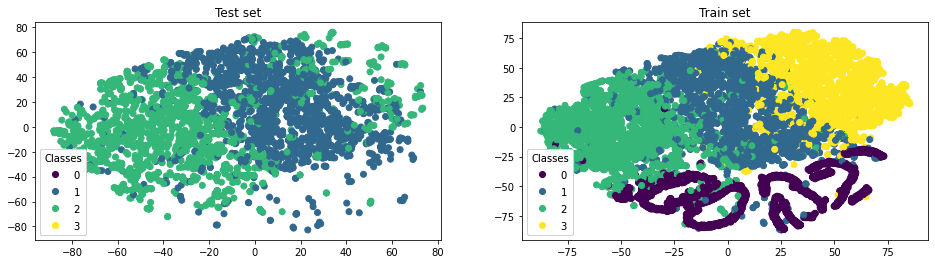

In [55]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize = [16,4])
colors = np.array(['r','g','b','c'])
te = y_te.clone()
te[0] = 0
te[-5] = 3
rng = np.random.default_rng(12345)
proj_train = projected[test_len:]
proj_test = projected[:test_len]

index_train = np.arange(len(proj_train))
index_test = np.arange(len(proj_test))

rng.shuffle(index_train)
rng.shuffle(index_test)



scatter = ax1.scatter(proj_test[index_test,0],proj_test[index_test,1],c=te[index_test])

legend1 = ax1.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax1.add_artist(legend1)
ax1.title.set_text("Test set")

scatter = ax2.scatter(proj_train[index_train,0],proj_train[index_train,1], c= Y_train[index_train])

legend1 = ax2.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax2.add_artist(legend1)
ax2.title.set_text("Train set")

plt.show()

In [45]:
rng

NameError: name 'rng' is not defined

## Train set

In [49]:
with torch.no_grad():
    out = model(X_train)

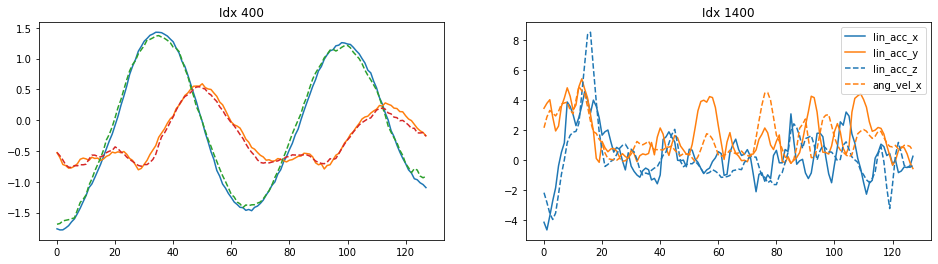

In [50]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize = [16,4])
plt.gca().set_prop_cycle(None)
ax1.plot(out[1][400].T)
plt.gca().set_prop_cycle(None)
ax1.plot(out[0][400].T, linestyle="--")
ax1.title.set_text("Idx 400")

plt.gca().set_prop_cycle(None)
ax2.plot(out[1][1400].T)
plt.gca().set_prop_cycle(None)
ax2.plot(out[0][1400].T, linestyle="--")
ax2.title.set_text("Idx 1400")
plt.legend(legend)
plt.show()

In [10]:
projected = TSNE(n_components=2).fit_transform(torch.flatten(out[2], start_dim=1))

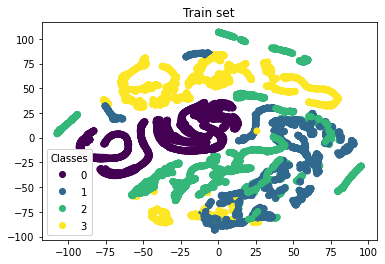

In [11]:
fig, ax = plt.subplots()
scatter = ax.scatter(projected[:,0],projected[:,1], c= Y_train)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.title.set_text("Train set")
plt.show()

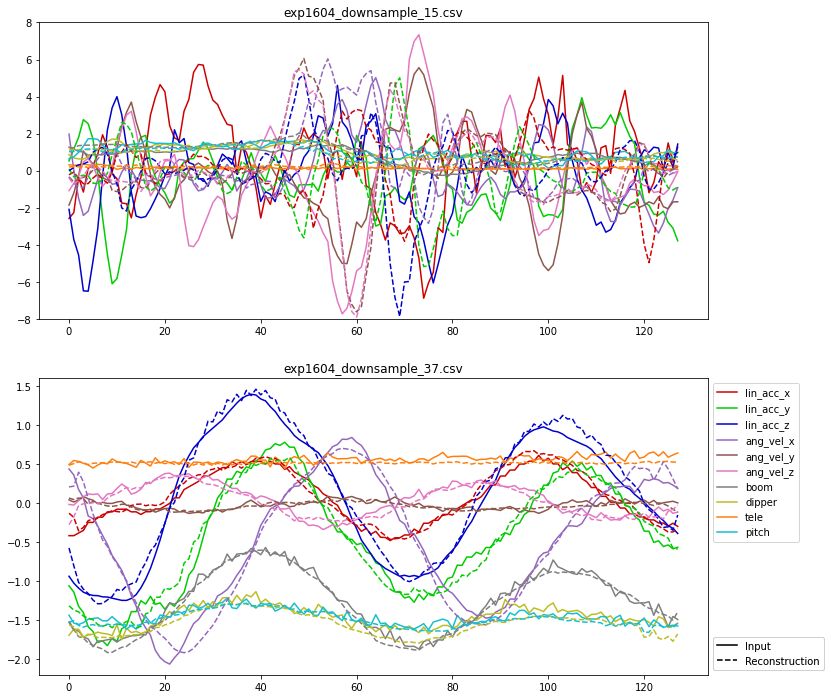

In [21]:
import matplotlib.lines as mlines
from cycler import cycler
idx = 120
legend = [labels[i-1] for i in variable_set[0]]
rows = 2
fig, ax1 = plt.subplots(rows,1,figsize = [12,6*rows])

custom_cycler = cycler(color=[[0.8,0,0], [0,0.8,0], [0,0,0.8], '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#ff7f0e','#17becf'])

fl = [files[2],files[-1]]
pl = [plotting[2],plotting[-1]]
oo = [output[2],output[-1]]

for a1,d,f,out in zip(ax1.reshape(-1),pl,fl,oo):
    a1.title.set_text(f)
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[1][idx].T)   
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[0][idx].T,linestyle="--")
legend1 = plt.legend(legend,bbox_to_anchor=(1., 1.0), loc='upper left')
inputs = mlines.Line2D([], [], color='black', ls='-', label='Input')
recs = mlines.Line2D([], [], color='black', ls='--', label='Reconstruction')
legend2 = plt.legend(handles=[inputs,recs],bbox_to_anchor=(1., 0), loc='lower left')
ax1[0].set_ylim([-8,8])
ax1[1].set_ylim([-2.2,1.6])
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend1)
plt.show()

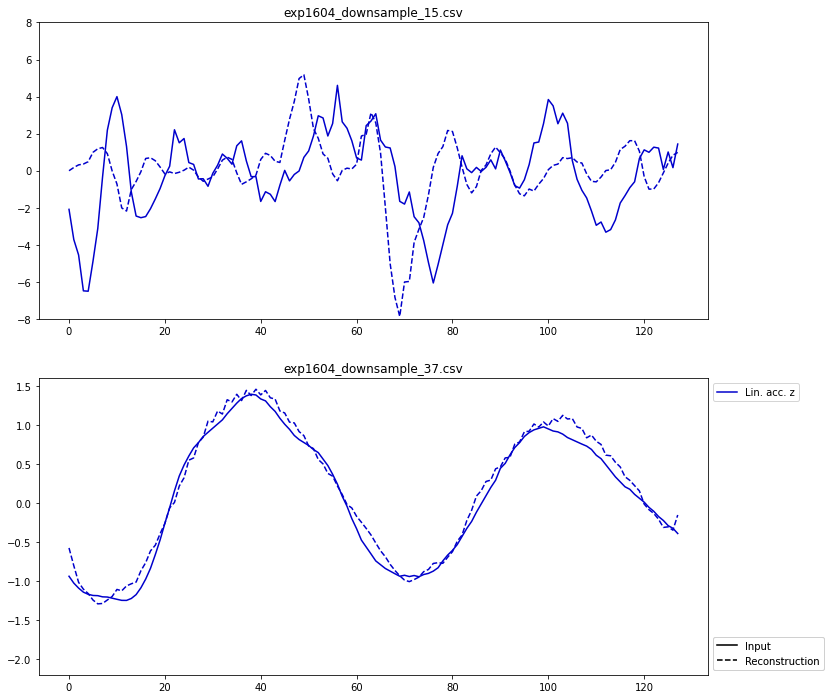

In [22]:
idx = 120
legend = [labels[i-1] for i in variable_set[0]]
rows = 2
fig, ax1 = plt.subplots(rows,1,figsize = [12,6*rows])

custom_cycler = cycler(color=[[0.8,0,0], [0,0.8,0], [0,0,0.8], '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#ff7f0e','#17becf'])

fl = [files[2],files[-1]]
pl = [plotting[2],plotting[-1]]
oo = [output[2],output[-1]]

for a1,d,f,out in zip(ax1.reshape(-1),pl,fl,oo):
    a1.title.set_text(f)
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[1][idx,2].T, color = [0,0,0.8])   
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[0][idx,2].T,color = [0,0,0.8],linestyle="--")
legend1 = plt.legend(["Lin. acc. z"],bbox_to_anchor=(1., 1.0), loc='upper left')
inputs = mlines.Line2D([], [], color='black', ls='-', label='Input')
recs = mlines.Line2D([], [], color='black', ls='--', label='Reconstruction')
legend2 = plt.legend(handles=[inputs,recs],bbox_to_anchor=(1., 0), loc='lower left')
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend1)
ax1[0].set_ylim([-8,8])
ax1[1].set_ylim([-2.2,1.6])
plt.show()